# Light Schrödinger Bridge Night to Day Domain Transform

This notebooks trains the LightSB model using the AutoencoderKL latents we generated. It will perform a grid search over the n_potentials, is_diagonal and epsilon parameters to get the best performing model.

Next, it performs a transformation on the night validation set. Finally, we decode these latents back into images using the encoder and save them separately to the data folder.

## Imports

In [1]:
import os, sys

# if colab, mount drive and get the git repo
if 'google.colab' in sys.modules:
    from google.colab import drive
    print(os.getcwd())
    drive.mount('/content/drive')
    !git clone --recurse-submodules https://github.com/jsluijter02/LightSB_YOLO

    # Append LightSB_YOLO path
    sys.path.append(os.path.join(os.getcwd(), 'LightSB_YOLO'))

    ## TODO: 

# otherwise local path append
else:
    sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import os, sys
import numpy as np
np.random.seed(0)
from argparse import Namespace
import copy

from scripts.utils import dirs
dirs.add_LIGHTSB_to_PATH()

from scripts.models.autoencoderkl import AutoencoderKL_BDD
from scripts.models.lightsb import LightSB_BDD
from scripts.evals.FID import latent_FID_score

/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


## LightSB Configs

In [3]:
sb_config = LightSB_BDD.standard_config()

epsilons = [0.01, 0.1, 0.5]
n_potentials = [10, 20]
is_diagonal = ...

## Load Data

In [4]:
train_day = np.load('../data/encodings/train_day_latents.npy')
train_night = np.load('../data/encodings/train_night_latents.npy')

val_day = np.load('../data/encodings/val_day_latents.npy')
val_night = np.load('../data/encodings/val_night_latents.npy')

np_data = {"train_day": train_day, 
           "train_night": train_night, 
           "val_day": val_day, 
           "val_night": val_night }

## Models

In [5]:
encoder = AutoencoderKL_BDD()
sb = LightSB_BDD(sb_config, np_data)

## Train SB with a Grid Search + Val Set Evaluation
Evaluation method: FID on latents.

Due to computational and time constraints, it is not possible to transform ALL images six times and produce FID-scores, so a latent-based proxy is taken to determine final LightSB model parameters. FID metric on images will be taken of the final image set.

Additionally, downstream the mAP of the YOLOPX algorithm will determine this method's succesfullness as a preprocessing step.

In [6]:
args = Namespace()

models = {}
fid_scores = {}
for eps in epsilons:
    for potential in n_potentials:
        print("Started process for: ", eps, " ", potential)
        # to reduce training time, reduce steps to 1000
        args.MAX_STEPS = 1000
        args.EPSILON = eps
        args.N_POTENTIALS = potential
        sb.update_config(args=args)
        sb.reload_model()

        model_name = f'{eps}_{potential}'

        sb.train()

        transformed = sb.transform(sb.X_test)

        fid = latent_FID_score(transformed, sb.Y_test)

        print(fid)

        models[model_name] = copy.deepcopy(sb.model.state_dict())
        fid_scores[model_name] = fid

Started process for:  0.01   10


100%|██████████| 1000/1000 [00:08<00:00, 111.55it/s]


76358.18918328408
Started process for:  0.01   20


100%|██████████| 1000/1000 [00:15<00:00, 62.96it/s]


76001.92826031333
Started process for:  0.1   10


100%|██████████| 1000/1000 [00:09<00:00, 111.04it/s]


75834.16056344338
Started process for:  0.1   20


100%|██████████| 1000/1000 [00:15<00:00, 62.97it/s]


75498.8317530738
Started process for:  0.5   10


100%|██████████| 1000/1000 [00:09<00:00, 107.08it/s]


74948.02344485321
Started process for:  0.5   20


100%|██████████| 1000/1000 [00:16<00:00, 61.21it/s]


74961.10200739602


## Test the models on the validation set
Evaluation method: FID on latents.

Due to computational and time constraints, it is not possible to transform ALL images six times and produce FID-scores, so a latent-based proxy is taken to determine final LightSB model parameters. FID metric on images will be taken of the final image set.

Additionally, downstream the mAP of the YOLOPX algorithm will determine this method's succesfullness as a preprocessing step.

## Transform Val Images with Best Model

In [7]:
best_cfg = LightSB_BDD.standard_config()
best_cfg.MODEL.EPSILON = 0.5
best_cfg.MODEL.N_POTENTIALS = 20

best_sb = LightSB_BDD(config=best_cfg, np_data=np_data)

best_sb.train()

best_transformed = sb.transform(sb.X_test)

100%|██████████| 10000/10000 [02:37<00:00, 63.61it/s]


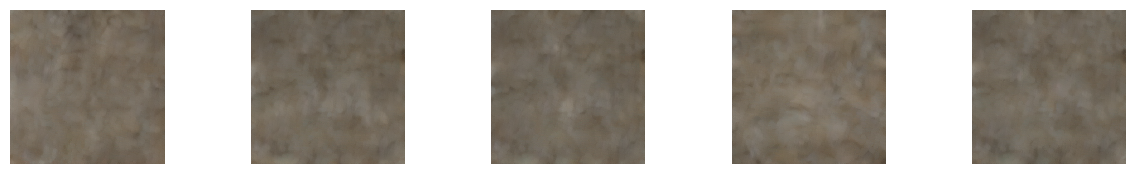

In [27]:
from scripts.utils import img
import diffusers

indices = img.sample_indices(len(best_transformed))
decoded =  encoder.decode_latents(best_transformed[indices], batch_size=10)
decoded_imgs = diffusers.utils.pt_to_pil(decoded)

img.plot_samples(decoded_imgs)